In [14]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from ml_wireless_classification.base.SignalUtils import extract_comprehensive_features
import matplotlib.pyplot as plt
import seaborn as sns

# Define selected features
SELECTED_FEATURES = [
    "Spectral Peak Ratio (Magnitude)",  # 0
    "Frequency Domain Entropy with High-Frequency Emphasis",  # 2
    "Wavelet Entropy Multiple Scales (Quadratic)"  # 3
]

# WBFM Demodulator
def wbfm_demodulate(iq_signal, sample_rate=1e6, deviation=75e3):
    phase = np.unwrap(np.angle(iq_signal))
    instantaneous_freq = np.diff(phase) / (2 * np.pi) * sample_rate
    demodulated = instantaneous_freq / deviation
    return np.pad(demodulated, (1, 0), mode="constant", constant_values=0)

# AM-DSB Demodulator
def am_dsb_demodulate(iq_signal):
    envelope = np.abs(iq_signal)
    demodulated = envelope - np.mean(envelope)
    return demodulated

# Filter modulations
def filter_modulations(data):
    filtered_data = {}
    for key, signals in data.items():
        mod_type, snr = key
        if mod_type in ["WBFM", "AM-DSB"]:
            filtered_data[(mod_type, snr)] = signals
        else:
            filtered_data[("Other", snr)] = signals
    return filtered_data

# Feature extraction
def extract_features_with_snr(data, selected_features, sample_rate=1e6):
    features, labels, snr_values = [], [], []

    for (mod_type, snr), signals in data.items():
        for signal in signals:
            iq_signal = signal[0] + 1j * signal[1]

            # Apply appropriate demodulator
            if mod_type == "WBFM":
                demodulated_signal = wbfm_demodulate(iq_signal, sample_rate)
            elif mod_type == "AM-DSB":
                demodulated_signal = am_dsb_demodulate(iq_signal)
            else:
                demodulated_signal = iq_signal.real

            # Extract features
            feature_dict = extract_comprehensive_features(demodulated_signal, selected_features)
            feature_dict["SNR"] = snr

            # Gather extracted features
            extracted = [feature_dict.get(f, 0) for f in selected_features] + [snr]
            features.append(extracted)
            labels.append(1 if mod_type == "WBFM" else 0)
            snr_values.append(snr)

    return np.array(features), np.array(labels), np.array(snr_values)

# Load dataset
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Filter data for WBFM, AM-DSB, and Other
filtered_data = filter_modulations(data)

# Extract features and labels
features, labels, snr_values = extract_features_with_snr(filtered_data, SELECTED_FEATURES)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)


In [15]:
from ml_wireless_classification.base.TestingUtils import convert_and_clean_data



# Split the data into training and testing sets, including SNR values
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(
    features, labels, snr_values, test_size=0.5, random_state=24
)

X_train = convert_and_clean_data(X_train)
y_train = convert_and_clean_data(y_train)

# Train the RandomForestClassifier for WBFM vs Other
wbfm_model = RandomForestClassifier(n_estimators=100, random_state=42)
wbfm_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

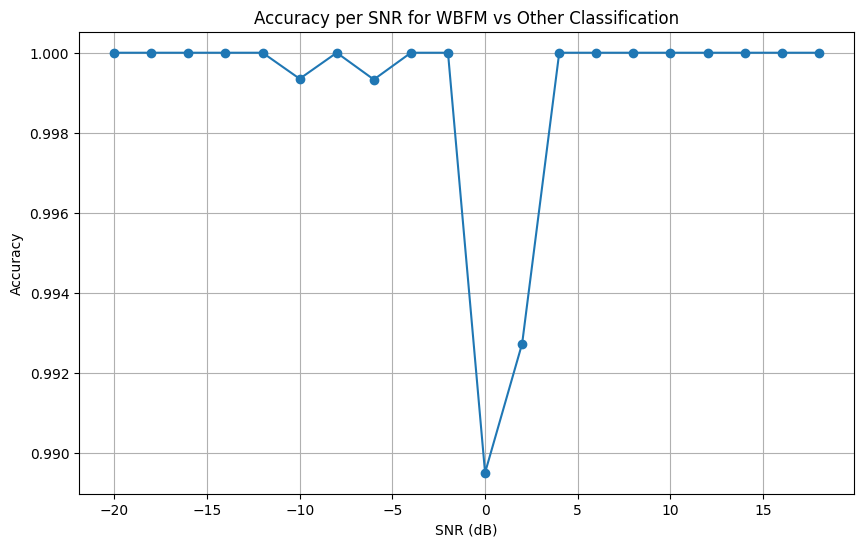

WBFM vs Other Model Performance
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00     19964
        WBFM       1.00      1.00      1.00     10036

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

[[19958     6]
 [   23 10013]]


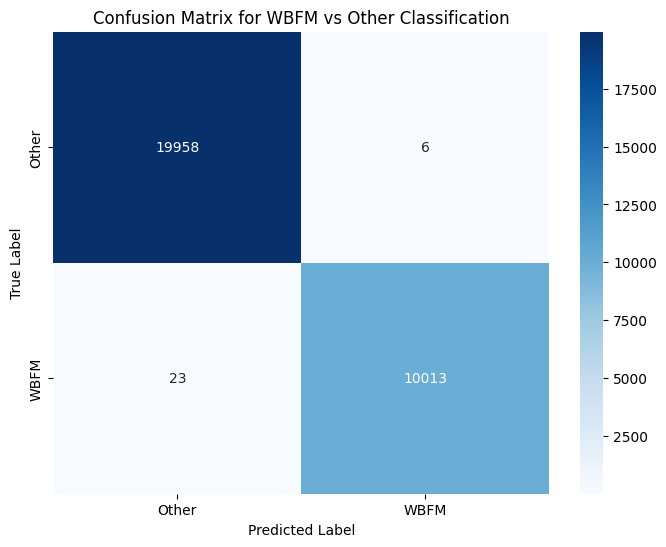

In [17]:

X_test = convert_and_clean_data(X_test)
y_test = convert_and_clean_data(y_test)

# Predictions and Evaluation
wbfm_pred = wbfm_model.predict(X_test)

# Convert y_test and wbfm_pred to NumPy arrays for indexing
y_test = np.array(y_test)
wbfm_pred = np.array(wbfm_pred)

# Compute accuracy per SNR
snr_accuracy = {}
unique_snr_values = np.unique(snr_test)

for snr in unique_snr_values:
    indices = np.where(snr_test == snr)
    accuracy = accuracy_score(y_test[indices], wbfm_pred[indices])
    snr_accuracy[snr] = accuracy

# Plotting accuracy per SNR
plt.figure(figsize=(10, 6))
plt.plot(list(snr_accuracy.keys()), list(snr_accuracy.values()), marker='o')
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Accuracy per SNR for WBFM vs Other Classification")
plt.grid(True)
plt.show()

# Display the confusion matrix for overall performance
print("WBFM vs Other Model Performance")
print(classification_report(y_test, wbfm_pred, target_names=["Other", "WBFM"]))
print(confusion_matrix(y_test, wbfm_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, wbfm_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Other", "WBFM"], yticklabels=["Other", "WBFM"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for WBFM vs Other Classification")
plt.show()